## Libraries

In [282]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Calculate some stuff

In [283]:
# get nytimes covid data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, error_bad_lines=False)

# pivot data from long to wide
df = df.pivot(index='date', columns='state', values='cases')

# clean up the data so blanks are zeros and numbers are integers
df = df.fillna(0)
df = df.astype(int)

# reset index (to make graph work)
df = df.reset_index()

# drop the most recent day's data
# some data doesn't get updated at the same time so if one state updated and another didnt, 
# the second one will show 'zero' which is misleading
df.drop(df.tail(1).index,inplace=True)

# drop territories (if you want to include territories, comment out this line)
df.drop(['Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands'], axis=1, inplace=True)

# get population data from wikipedia
WIKI_URL = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"
df_pop = pd.read_html(WIKI_URL, header=0)

# fix the population dataframe, it ends up inside a list for some reason
df_pop = df_pop[0]

# delete all the columns execpt for "Population estimate, July 1, 2019[2]" and "State"
for columns in df_pop.columns:
   if columns not in ["Population estimate, July 1, 2019[2]", "State"]:
      df_pop.drop([columns], axis=1, inplace=True)

# Rename "Population estimate, July 1, 2019[2]" to "Population"
df_pop.rename(columns={"Population estimate, July 1, 2019[2]": "Population"}, inplace=True)

# Drop the terretories and totals, etc (If you want to include territories, comment out this line)
df_pop.drop([31, 52, 53, 54, 55, 56, 57, 58, 59], inplace=True)

# sort list alphabetically by state name (not necessary, but it makes me feel better)
df_pop = df_pop.sort_values("State")
df_pop = df_pop.reset_index()
df_pop.drop(["index"], axis=1, inplace=True)
df_pop.set_index("State", inplace=True)


# Make dataframe for total cases
df_total = df.copy()

# Make dataframe for cases per captia
df_total_percapita = df.copy()
for c in df_total_percapita.columns:
    if c in ['date']:
        pass
    else:
        df_total_percapita[c] = df_total_percapita[c]/df_pop['Population'][c]*100000

# Make dataframe for DELTA (i.e. new cases per day)
df_delta = df.copy()
df_delta.drop(['date'], axis=1, inplace=True) # we have to drop the date column or diff will be upset
df_delta = df_delta.diff()
df_delta['date'] = df['date'] # add date column back in
df_delta = df_delta[ ['date'] + [ col for col in df_delta.columns if col != 'date' ] ] # move date column to beginning

# Make dataframe for DELTA per captita
df_delta_percapita = df_delta.copy()
for c in df_delta_percapita.columns:
    if c in ['date']:
        pass
    else:
        df_delta_percapita[c] = df_delta_percapita[c]/df_pop['Population'][c]*100000

## Function to make chart

In [292]:
def make_chart(data, state, title):
    # Note: `df.index[-1]` == length of the dataframe. ie if there are 74 days of data, df.index[-1] == 74

    # get dataframe and add average column
    df = data
    df['average'] = df.mean(numeric_only=True, axis=1)
    
    # colors
    colors = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a"]
    
    # top ten or five or whatever states by number of cases
    top_ten = df.max().drop('date').sort_values(ascending=False).head(5).index

    # some chart styling stuff
    plt.style.use('bmh')
    my_dpi=96
    plt.figure(figsize=(1080/my_dpi, 720/my_dpi), dpi=my_dpi)
    plt.xticks(rotation=90)
    # plt.yscale("log")
 
    # thin lines for each state
    for column in df.drop('date', axis=1):
        plt.plot(df['date'], df[column], marker='', color='grey', linewidth=.5, alpha=0.5, label=column)
      
    # colorize top 10 lines
    c = 0
    for i in top_ten:
        plt.plot(df['date'], df[i], marker='', color=colors[c], linewidth=1, alpha=0.7)
        c += 1

    # colorize and bold the line for the particular state we specify and average
    plt.plot(df['date'], df[state], marker='', color='#386cb0', linewidth=4, alpha=0.7)
    plt.plot(df['date'], df['average'], marker='', color='black', linewidth=5, alpha=0.9)


    # Change xlim (e.g. last two weeks = [-14] = start 14 days ago, [-1] start today)
    plt.xlim(df.index[-30],df.index[-1])
 
    # add labels to the thin lines
    num=0
    for i in df.values[df.index[-1]][1:]:
        num+=1
        name=list(df)[num]
        if name != state and name not in top_ten:
            plt.text(df.index[-1], i, name, horizontalalignment='left', fontsize=6, color='grey')
 
    # colorize top 5 states labels
    c = 0
    for i in top_ten:
        plt.text(df.index[-1], df[i].tail(1), i, horizontalalignment='left', fontsize=16-(c*2), color=colors[c])
        c += 1
    
    # colorize the lines for the state we specify and average
    plt.text(df.index[-1], df[state].tail(1), state, horizontalalignment='left', fontsize=16, color='#386cb0')
    plt.text(df.index[-1], df['average'].tail(1), 'Average', horizontalalignment='left', fontsize=16, color='black')

 
    # Add titles
    plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Time")
    plt.ylabel("Cases")

## Total Cases

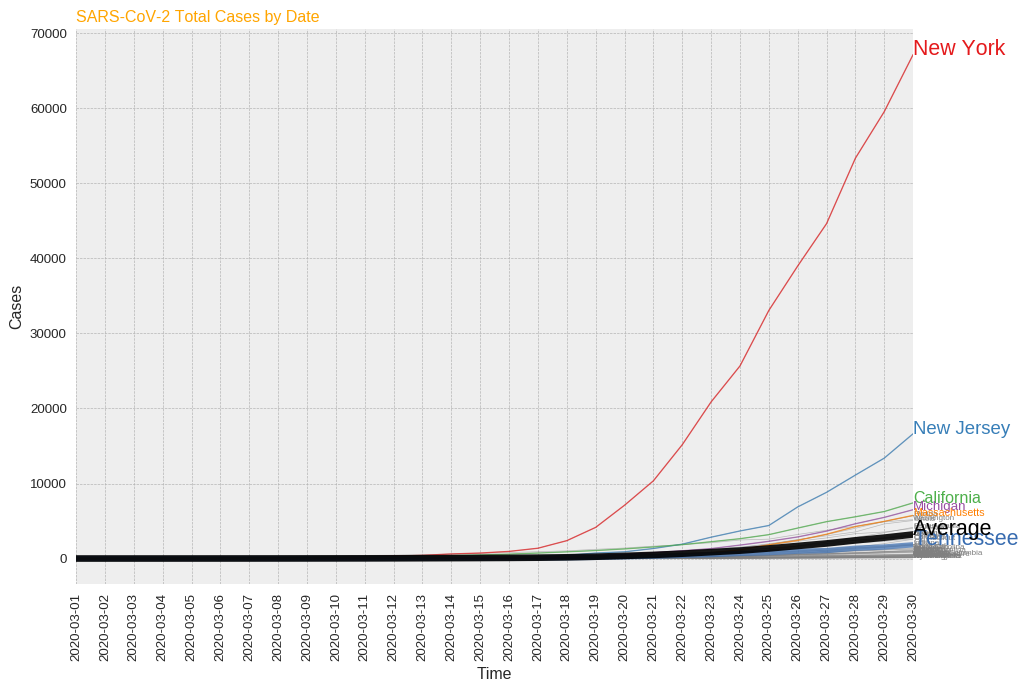

In [293]:
make_chart(df_total, "Tennessee", "SARS-CoV-2 Total Cases by Date")

## New Cases

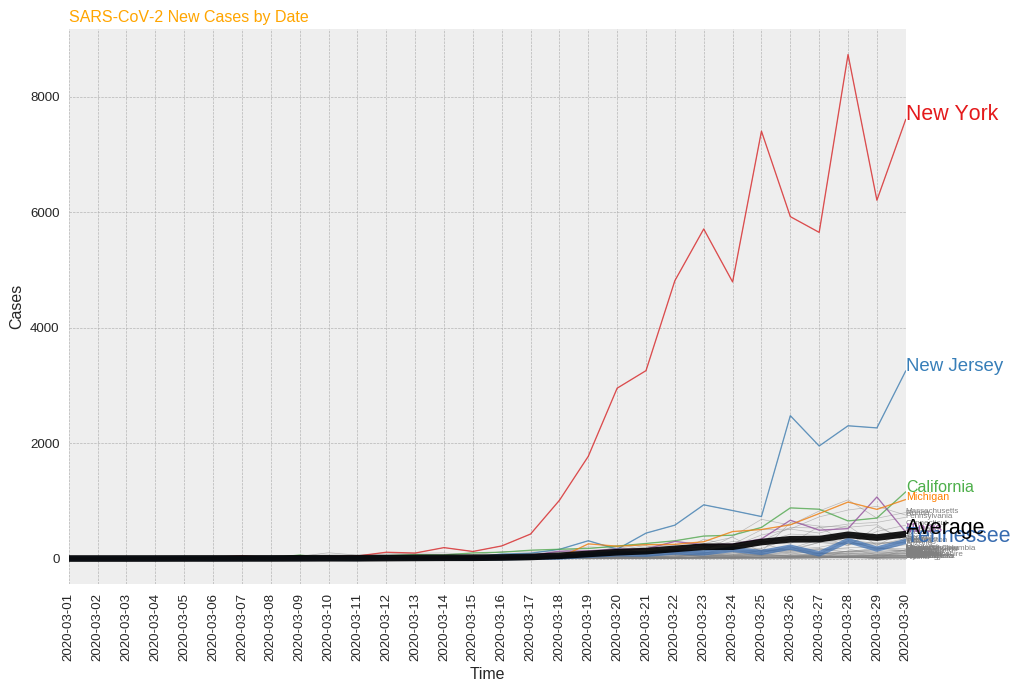

In [294]:
make_chart(df_delta, "Tennessee", "SARS-CoV-2 New Cases by Date")

## Total Cases per capita

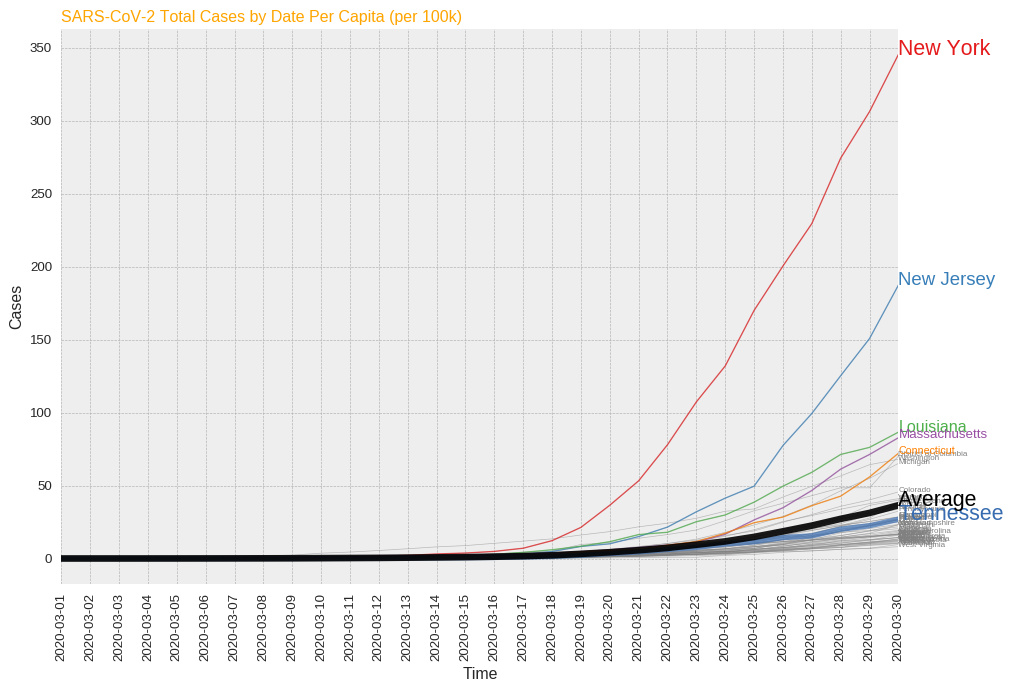

In [295]:
make_chart(df_total_percapita, "Tennessee", "SARS-CoV-2 Total Cases by Date Per Capita (per 100k)")

## New Cases per capita

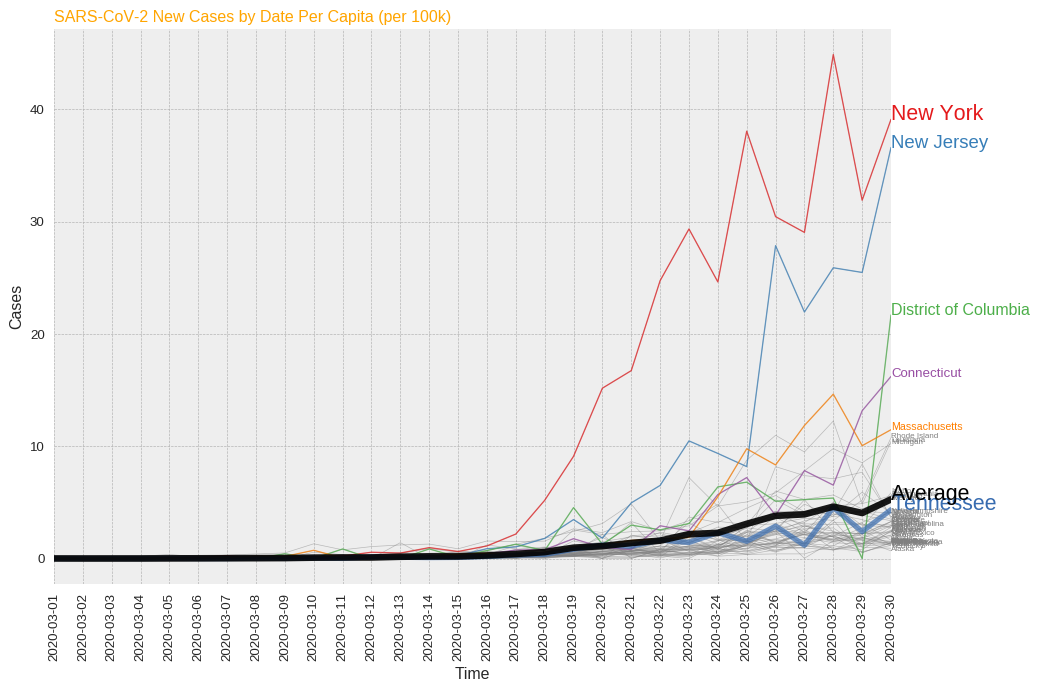

In [296]:
make_chart(df_delta_percapita, "Tennessee", "SARS-CoV-2 New Cases by Date Per Capita (per 100k)")

## Tennessee Data
#### Total Cases last N days

In [289]:
df["Tennessee"].tail(10)

60     312
61     424
62     522
63     679
64     784
65     981
66    1062
67    1373
68    1537
69    1834
Name: Tennessee, dtype: int64

### New Cases last N days

In [290]:
df_delta["Tennessee"].tail(10)

56     21.0
57     25.0
58     57.0
59     82.0
60     75.0
61    112.0
62     98.0
63    157.0
64    105.0
65    197.0
66     81.0
67    311.0
68    164.0
69    297.0
Name: Tennessee, dtype: float64

In [291]:
# df_test = df_delta.copy()
# df_test.drop(["New York", "New Jersey"], axis=1, inplace=True)